# Try the interpolation on synthetic data

In [1]:
import itertools
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import KFold
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D

Crop the synthetic data to a smaller region focused around the fault system.

In [2]:
data = xr.open_dataset('../../data/synthetic-san-andreas-2017.nc')
region = [-123, -115, 32, 40]
data = data.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))
data

<xarray.Dataset>
Dimensions:         (latitude: 133, longitude: 133)
Coordinates:
  * longitude       (longitude) float64 -123.0 -122.9 -122.9 -122.8 -122.7 ...
  * latitude        (latitude) float64 32.02 32.08 32.14 32.2 32.26 32.32 ...
Data variables:
    east_velocity   (latitude, longitude) float32 ...
    north_velocity  (latitude, longitude) float32 ...
    up_velocity     (latitude, longitude) float32 ...

Setup a map projection.

In [3]:
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

In [4]:
def plot_data(data, every=3):
    """
    Plot the 3 data components in 2 maps.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 7.5),
                             subplot_kw=dict(projection=ccrs.Mercator()))
    crs = ccrs.PlateCarree()
    # Plot the horizontal components
    ax = axes[0]
    if data.east_velocity.ndim == 1:
        east = data.east_velocity.values[::every]
        north = data.north_velocity.values[::every]
    else:
        east = data.east_velocity.values[::every, ::every]
        north = data.north_velocity.values[::every, ::every]
    tmp = ax.quiver(data.longitude.values[::every], 
                    data.latitude.values[::every],
                    east, north, scale=300, width=0.0015, 
                    transform=crs)
    ax.set_title('Horizontal velocity')
    # Plot the vertical component
    ax = axes[1]
    if data.up_velocity.ndim == 1:
        pc = ax.scatter(data.longitude, data.latitude, 
                        c=data.up_velocity, s=10, cmap='seismic', 
                        vmin=-3, vmax=3, transform=crs)    
    else:
        pc = ax.pcolormesh(data.longitude, data.latitude, data.up_velocity, 
                           cmap='seismic', vmin=-3, vmax=3,
                           transform=crs)
        ax.coastlines()
    plt.colorbar(pc, ax=ax, pad=0, aspect=50).set_label('mm/yr')
    ax.set_title('Vertical velocity')
    ax.quiverkey(tmp, 0.60, 0.10, 30, label='30 mm/yr', coordinates='figure')    
    # Setup the axis labels and ticks
    for ax in axes:
        # Setup the map ticks
        ax.set_xticks(np.arange(-123, -113, 2), crs=crs)
        ax.set_yticks(np.arange(32, 42, 2), crs=crs)
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.add_feature(cfeature.LAND, facecolor='gray')
        ax.add_feature(cfeature.OCEAN)
        ax.set_extent(region, crs=crs)
    plt.tight_layout(w_pad=0)
    return fig, axes

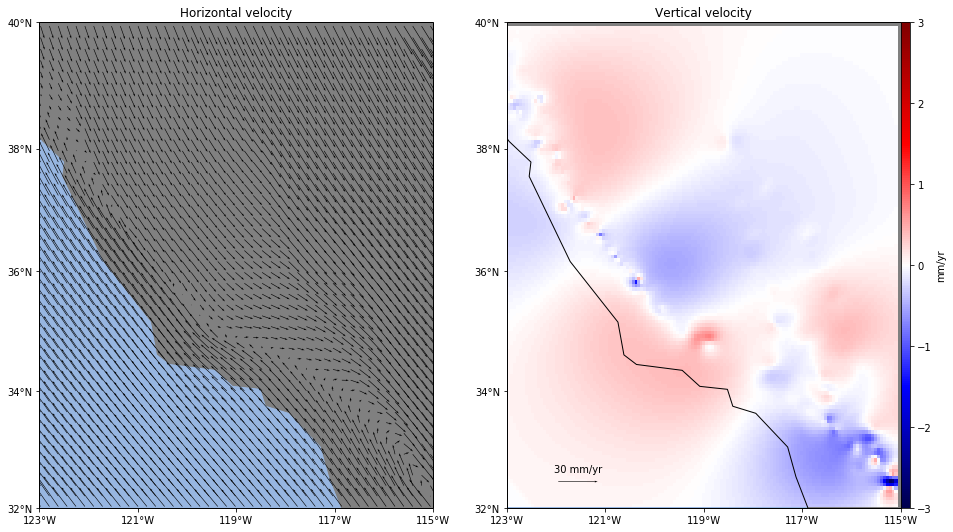

In [5]:
fig, axes = plot_data(data)

Setup a reduced version of the data that we'll use in the actual interpolation.

In [6]:
spacing = 0.15
blockmean = vd.BlockReduce(np.mean, region=region, spacing=spacing, 
                           center_coordinates=True)
block_coords, block_data = blockmean.filter(np.meshgrid(data.longitude, data.latitude),
                                            (data.east_velocity.values, 
                                             data.north_velocity.values, 
                                             data.up_velocity.values))
reduced = pd.DataFrame({'east_velocity': block_data[0], 'north_velocity': block_data[1], 
                        'up_velocity': block_data[2], 'latitude': block_coords[1], 
                        'longitude': block_coords[0]})
reduced.head()

,east_velocity,north_velocity,up_velocity,latitude,longitude
0,-18.706850,22.654358,-0.007421,32.075472,-122.924528
1,-18.701962,22.695793,-0.011252,32.075472,-122.773585
2,-16.695988,19.974449,0.007408,32.075472,-122.622642
3,-12.845934,14.632750,0.046828,32.075472,-122.471698
4,-12.359818,13.882936,0.050965,32.075472,-122.320755


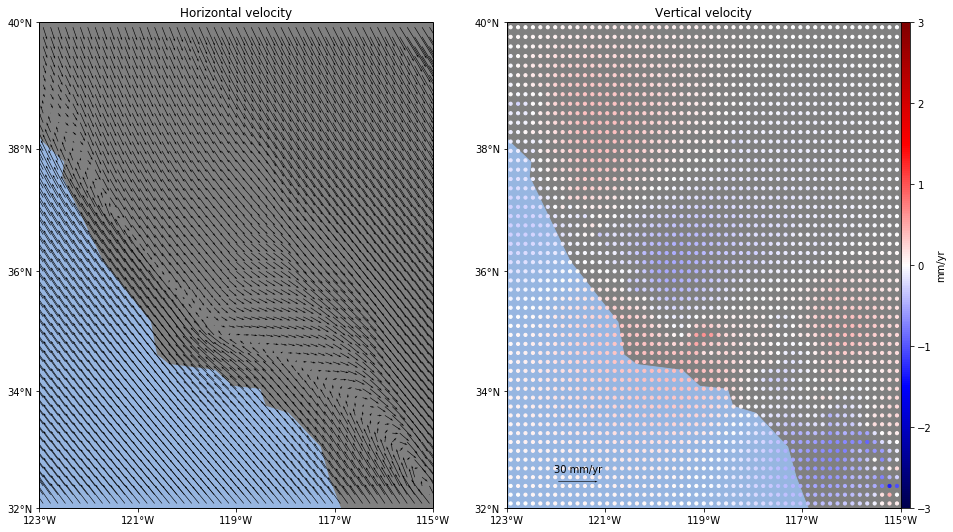

In [7]:
fig, axes = plot_data(reduced, every=1)

## Sample the synthetic data

In [8]:
def longitude_shift(lon, allpositive=True, copy=True):
    """
    Shift longitude between [-180, 180] and [0, 360].
    """
    if copy:
        shifted = lon.copy()
    else:
        shifted = lon
    if allpositive:
        negative = shifted < 0
        shifted[negative] = 360 + shifted[negative]
    else:
        over = shifted > 180
        shifted[over] = shifted[over] - 360
    return shifted

Take the samples as the nearest neighbors of the real data points.

In [9]:
gpsdata = vd.datasets.fetch_california_gps()
gpsdata['longitude'] = longitude_shift(gpsdata.longitude, allpositive=False)
gpsdata = gpsdata[vd.inside((gpsdata.longitude, gpsdata.latitude), region)]
gpsdata.head()

,latitude,longitude,height,velocity_north,velocity_east,velocity_up,std_north,std_east,std_up
0,34.116409,-117.093196,762.11978,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
1,34.116409,-117.093196,762.10883,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
2,34.116409,-117.093195,762.09364,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
3,34.116409,-117.093195,762.09073,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
4,34.116409,-117.093195,762.07699,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053


In [10]:
def sample_from_grid(grid, coordinates=None, size=None, random_state=None):
    """
    Extact uniformly random samples from an grid.
    """
    if coordinates is None:
        if isinstance(random_state, int):
            random_state = np.random.RandomState(random_state)
        elif random_state is None:
            random_state = np.random.RandomState()
        coords = {name: xr.DataArray(random_state.randint(0, grid[name].size, size=size), dims='p')
                  for name in grid.coords}
        sampled_grid = grid.isel(**coords)
    else:
        coords = {name: xr.DataArray(coordinates[name], dims='p')
                  for name in coordinates}
        sampled_grid = grid.sel(**coords, method='nearest')
    columns = {name: sampled_grid[name].values for name in grid.data_vars}
    for name in coords:
        columns[name] = sampled_grid[name].values    
    sample = pd.DataFrame(columns)
    return sample    

In [11]:
sample = sample_from_grid(data, dict(longitude=gpsdata.longitude, latitude=gpsdata.latitude))
sample.head()

,east_velocity,north_velocity,up_velocity,longitude,latitude
0,1.301804,2.155317,-0.07127,-117.096312,34.1225
1,1.301804,2.155317,-0.07127,-117.096312,34.1225
2,1.301804,2.155317,-0.07127,-117.096312,34.1225
3,1.301804,2.155317,-0.07127,-117.096312,34.1225
4,1.301804,2.155317,-0.07127,-117.096312,34.1225


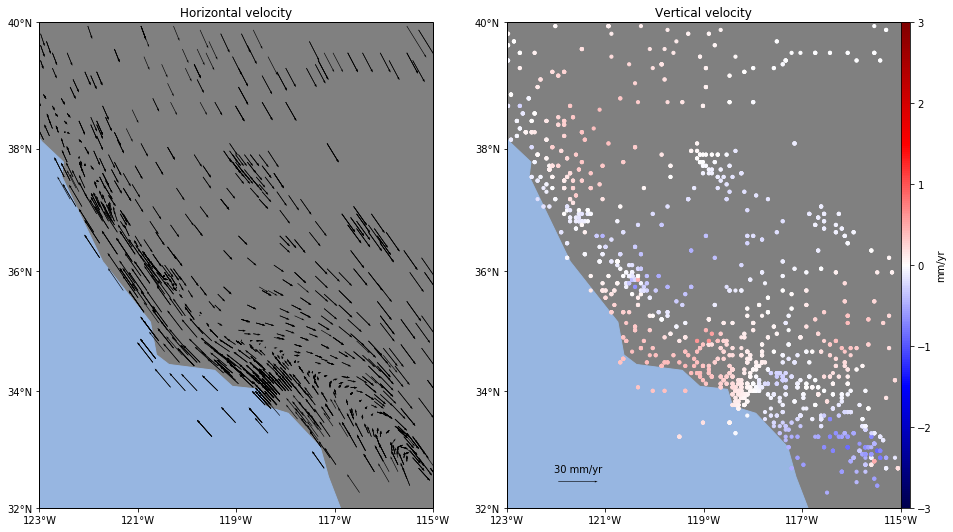

In [12]:
fig, axes = plot_data(sample, every=1)

## Simple gridding

In [13]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=1000, poisson=0.5))
])
chain.fit(proj(sample.longitude.values, sample.latitude.values), 
          (sample.east_velocity, sample.north_velocity, sample.up_velocity))

Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7fa12c300d08>, region=None,
      spacing=15000.0)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=None, depth=1000, fudge=1e-05, poisson=0.5, region=None,
     shape=None, spacing=None))])

In [14]:
score = chain.score(proj(reduced.longitude.values, reduced.latitude.values), 
                    (reduced.east_velocity, reduced.north_velocity, reduced.up_velocity))
print("R2 score:", score)

R2 score: 0.501314597560935


In [15]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(reduced.longitude.values, reduced.latitude.values))
    res = reduced.copy()    
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    for pred, name in zip(predicted, names):
        res[name] = reduced[name] - pred
    return res

In [16]:
residuals = make_residuals(chain)
residuals.describe()

,east_velocity,north_velocity,up_velocity,latitude,longitude
count,2809.000000,2809.000000,2809.000000,2809.000000,2809.000000
mean,-0.226303,-0.277102,-0.019074,36.000000,-119.000000
std,4.421451,4.815594,0.223168,2.309401,2.309401
min,-14.598642,-15.219166,-2.164282,32.075472,-122.924528
25%,-2.611334,-2.899999,-0.121507,34.037736,-120.962264
50%,-0.122985,-0.243411,0.000040,36.000000,-119.000000
75%,2.347880,2.263648,0.112873,37.962264,-117.037736
max,12.821301,14.039069,1.554295,39.924528,-115.075472


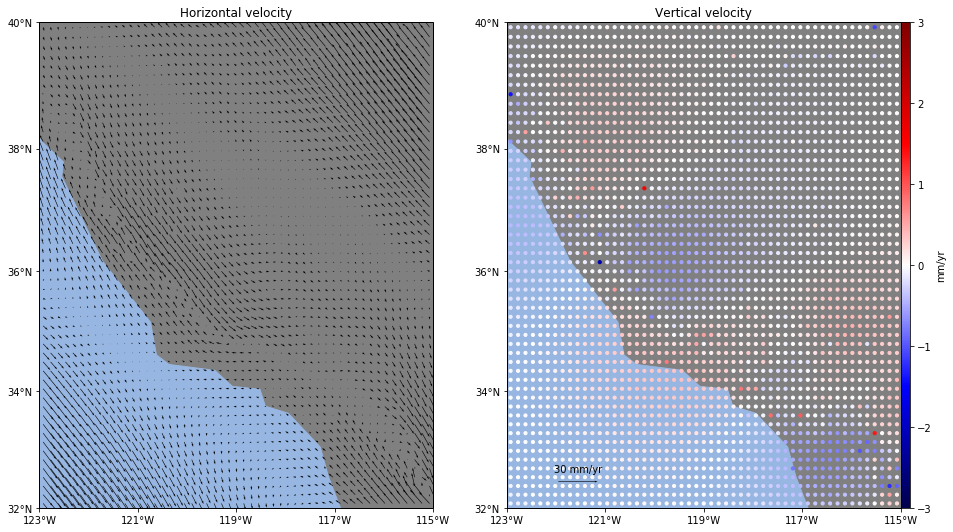

In [17]:
fig, axes = plot_data(residuals, every=1)

## Cross-validated

In [18]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44363 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.70 GB


In [19]:
def combinations(**kwargs):
    """
    Iterate over dictionaries of all combinations of the given arguments.
    """
    names = list(kwargs.keys())
    options = [kwargs[name] for name in names]
    combs = [dict(zip(names, comb)) for comb in itertools.product(*options)]
    return combs

In [24]:
%%time
proj_region = vd.project_region(region, proj)
proj_coordinates = proj(sample.longitude.values, sample.latitude.values)
fit_data = (sample.east_velocity, sample.north_velocity, sample.up_velocity)

param_grid = combinations(
    spacing=[spacing*100e3*factor for factor in [3, 3.5, 4]],
    damping=[10**i for i in range(-5, 1, 1)],
    depth=[1000],
    poisson=[-1, 0, 0.5],
)
print("spacings:", set(i['spacing'] for i in param_grid))

cv = KFold(n_splits=3, shuffle=True, random_state=0)

chains = []
scores = []
for params in param_grid:
    chain = vd.Chain([
        ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
        ('trend', vd.VectorTrend(1)),
        ('spline', Vector3D(region=proj_region, **params))
    ])
    chains.append(chain)
    score = vd.cross_val_score(chain, proj_coordinates, fit_data, 
                               client=client, cv=cv)
    scores.append(client.submit(np.mean, score))
best = client.submit(np.argmax, scores).result()
print("Best score:", scores[best].result())
chain = chains[best].fit(proj_coordinates, fit_data)
print(chain)

spacings: {45000.0, 52500.0, 60000.0}


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [25]:
score = chain.score(proj(reduced.longitude.values, reduced.latitude.values), 
                    (reduced.east_velocity, reduced.north_velocity, reduced.up_velocity))
print("R2 score:", score)

NotFittedError: This Chain instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
residuals = make_residuals(chain)
residuals.describe()

In [ ]:
fig, axes = plot_data(residuals, every=1)